# [Image Analyzer](#section1) 
<a id="section1"></a>
## Example using PySpark and Scikit-learn
* Follow the steps in <a href="https://github.com/ContinuumIO/image-analyzer/blob/master/run_helper.sh">run_helper.sh</a>, while using the default hdfs file naming in <a href="https://github.com/ContinuumIO/image-analyzer/blob/master/config.yaml">config.yaml</a>
* Then run each ipython notebook cell below to look at results
* If the notebook examples do not work, check your config.yaml against the config shown at the bottom of the notebook
* This notebook uses the example faces image <a href="http://cswww.essex.ac.uk/mv/allfaces/faces94.html">data set of Dr. Libor Spacek</a>

In [1]:
%env JAVA_HOME=/usr/lib/jvm/java-7-openjdk-amd64
%matplotlib inline
from __future__ import print_function, division
from pyspark import SparkConf
from pyspark import SparkContext 
from StringIO import StringIO
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint

conf = SparkConf()
conf.set('spark.executor.instances', 10)
sc = SparkContext()


env: JAVA_HOME=/usr/lib/jvm/java-7-openjdk-amd64


### [Example of each image's output](#map_each_image)
<a id="map_each_image"></a>
#### These measurements are done for training and candidate images
#### On each training or candidate image, the measurements may also be applied to patches
#### The relevant code for this is <a href="https://github.com/ContinuumIO/image-analyzer/blob/master/map_each_image.py">map_each_image.py.</a> <i> (The function "example" in map_each_image.py can do these measurements locally on an image file.)</i>
* Kmeans centroids
* Histogram
* Perceptive hashes (abbrev.)
* Ward cluster hashes (abbrev.) (hashing the output of the function seen in <a href="http://scikit-learn.org/stable/auto_examples/cluster/plot_lena_ward_segmentation.html">this scikit demo</a>
* Prinicipal components

In [2]:
example = sc.pickleFile('hdfs:///t1/map_each_image/measures').take(1)[0]
print("Keys:", example[1].keys())
print("Centroids in 1 image flattened:", example[1]['cen'])
print("Histogram flattened:", example[1]['histo'])
print("Perceptive hash (abbrev.):", example[1]['phash'][:5])
print("Ward cluster hash (abbrev.):", example[1]['ward'][:5])
print('PCA factors and variance', example[1]['pca_fac'], example[1]['pca_var'])

Keys: ['cen', 'pca_var', 'meta', 'phash', 'histo', 'ward', 'pca_fac', 'id']
Centroids in 1 image flattened: [ 0.13421966  0.11392961  0.10815033  0.5098421   0.74033761  0.30310148
  0.98272139  0.90371281  0.67363358  0.31632408  0.25163591  0.24269916
  0.60899442  0.4555634   0.43695211  0.06181042  0.06237328  0.05353779
  0.51379192  0.6508072   0.22041245  0.21634965  0.18442234  0.16989411
  0.84745359  0.67901754  0.58017242  0.41978663  0.32612464  0.3363423
  0.56250596  0.72074562  0.42683929  0.29966405  0.39516705  0.17478941]
Histogram flattened: [ 0.04692698  0.09493703  0.14686655  0.3787314   0.51634127  0.8463434
  0.05265678  0.08415315  0.12097912  0.31572431  0.72946459  0.76495057
  0.04111351  0.07947515  0.11634128  0.22291245  0.31090897  0.54049444]
Perceptive hash (abbrev.): []
Ward cluster hash (abbrev.): (2470317628725495884, -8238206338916862869, -1719196287905606517, -3613783094654589502, 6210940341358338849)
PCA factors and variance [-0.58624668 -0.73521

### Based on the data above for each image, a kmeans algorithm is run for all training images
#### The kmeans algorithm also tracks the most common perceptive hashes and ward cluster hashes
#### <a href="https://github.com/ContinuumIO/image-analyzer/blob/master/image_mapper.py">image_mapper.py</a> has the iterative kmeans loop on all images
* This shows cluster to hash lookups

In [3]:
print('Kmeans cluster to perceptive hash')
pprint(sc.pickleFile("hdfs:///t1/km/cluster_to_phash").take(2))

print('Kmeans cluster to Ward cluster hash')
pprint(sc.pickleFile("hdfs:///t1/km/cluster_to_phash").take(2))

Kmeans cluster to perceptive hash
[]
Kmeans cluster to Ward cluster hash
[]


### [Also we save the inverse mappings of hash to cluster](#mappings)
<a id="mappings"></a>
#### This provides several ways to search for images by hash or kmeans cluster
#### In <a href="https://github.com/ContinuumIO/image-analyzer/blob/master/config.yaml">config.yaml</a>, see the kmeans_output dictionary that controls which lookup tables are created

In [4]:
print('Perceptive hash to kmeans cluster')
pprint(sc.pickleFile("hdfs:///t1/km/phash_to_cluster").take(2))

print("Ward cluster hash to kmeans cluster")
pprint(sc.pickleFile("hdfs:///t1/km/ward_to_cluster").take(2))

Perceptive hash to kmeans cluster
[]
Ward cluster hash to kmeans cluster
[(2470317628725495884, 0), (-8238206338916862869, 0)]


### [Hash counts in kmeans clusters](#hash_counts)
<a id="hash_counts"></a>
#### A dictionary for each kmeans cluster counts the most common N hashes per cluster
* This shows the top ward cluster hashes in kmeans cluster with index 0

In [5]:
clust0_ward = sc.pickleFile('hdfs:////t1/km/ward_unions').take(1)[0]
pprint({k:v for k,v in clust0_ward.items()})

{-8180101903461685392: 1,
 -6439366262116039212: 2,
 -5013803343762532022: 1,
 -3831614152369362579: 1,
 -3794011296787580194: 1,
 -1719196287905606517: 1,
 -269990537081547852: 1,
 281200309521801431: 1,
 545747693385035224: 1,
 6260028877359341861: 1,
 8004063079426072408: 1}


### Using joins to finally get a matching image name
#### These examples are ward hash to image key and perceptive hash to image key mappings

In [6]:
print('ward_to_key\n')
pprint(sc.pickleFile('hdfs:///t1/km/ward_to_key').take(2))
print('\n\nphash_to_key\n')
pprint(sc.pickleFile('hdfs:///t1/km/phash_to_key').take(2))

ward_to_key

[(2470317628725495884,
  u'hdfs://ip-10-123-209-104:9000/imgs/maleambarwambarw.16.jpg'),
 (-8238206338916862869,
  u'hdfs://ip-10-123-209-104:9000/imgs/maleambarwambarw.16.jpg')]


phash_to_key

[]


### [Joins lead to a number of potentially matching images](#vote_count)
<a id="vote_count"></a>
* The example below shows the number of ward hash chunks matching a candidate
* The candidate has a path name /fuzzy/
* The others are the originals in /imgs/

In [7]:
ward_matches = sc.pickleFile('hdfs:///t1/candidates/c1/ward_to_key_counts')
phash_matches = sc.pickleFile('hdfs:///t1/candidates/c1/phash_to_key_counts')

wm = ward_matches.collect()
pm = phash_matches.collect()

In [8]:
joined = ward_matches.fullOuterJoin(phash_matches)

def best_votes(x):
    
    if x[1][0] is None:
        d1 = {}
    else:
        d1 = x[1][0][1]
    if x[1][1] is None:
        d2 = {}
    else:
        d2 = x[1][1][1]
    for k in d1:
        if k not in d2:
            d2[k] = d1[k]
        else:
            d2[k] += d1[k]
    d3 = sorted(d2.items(), key=lambda x:x[1])[-1]
    return x[0],(d3,d2)
phash_and_ward = joined.map(best_votes).collect()
print("Example votes dictionary:")
pprint(phash_and_ward[0])

Example votes dictionary:
(u'hdfs://ip-10-123-209-104:9000/fuzzy/maleohparkohpark.13.jpg',
 ((u'hdfs://ip-10-123-209-104:9000/imgs/maleohparkohpark.13.jpg', 48960),
  {u'hdfs://ip-10-123-209-104:9000/imgs/maleambarwambarw.16.jpg': 14400,
   u'hdfs://ip-10-123-209-104:9000/imgs/maledagrandagran.12.jpg': 31680,
   u'hdfs://ip-10-123-209-104:9000/imgs/malejagrifjagrif.11.jpg': 33840,
   u'hdfs://ip-10-123-209-104:9000/imgs/malekhughekhughe.5.jpg': 11520,
   u'hdfs://ip-10-123-209-104:9000/imgs/maleohparkohpark.13.jpg': 48960,
   u'hdfs://ip-10-123-209-104:9000/imgs/malernpwilrnpwil.2.jpg': 22320}))


#### Loading and comparing historical and matched images

Candidate (fuzzy)  hdfs://ip-10-123-209-104:9000/fuzzy/maleohparkohpark.13.jpg
Matched (original)  hdfs://ip-10-123-209-104:9000/imgs/maleohparkohpark.13.jpg


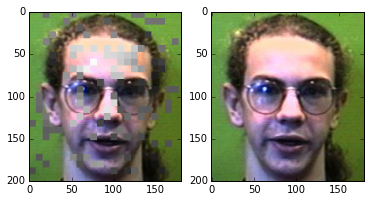

Candidate (fuzzy)  hdfs://ip-10-123-209-104:9000/fuzzy/malejagrifjagrif.11.jpg
Matched (original)  hdfs://ip-10-123-209-104:9000/imgs/malejagrifjagrif.11.jpg


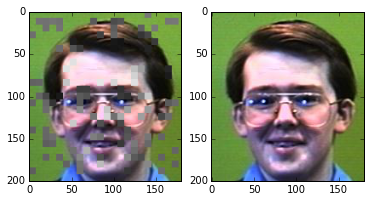

Candidate (fuzzy)  hdfs://ip-10-123-209-104:9000/fuzzy/maledagrandagran.12.jpg
Matched (original)  hdfs://ip-10-123-209-104:9000/imgs/maledagrandagran.12.jpg


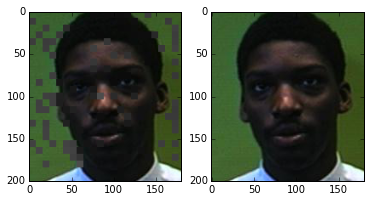

Candidate (fuzzy)  hdfs://ip-10-123-209-104:9000/fuzzy/malekhughekhughe.5.jpg
Matched (original)  hdfs://ip-10-123-209-104:9000/imgs/malekhughekhughe.5.jpg


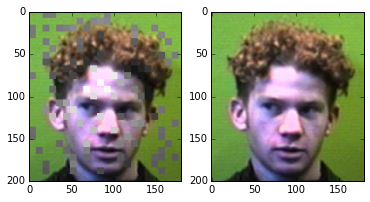

Candidate (fuzzy)  hdfs://ip-10-123-209-104:9000/fuzzy/maleambarwambarw.16.jpg
Matched (original)  hdfs://ip-10-123-209-104:9000/imgs/maleambarwambarw.16.jpg


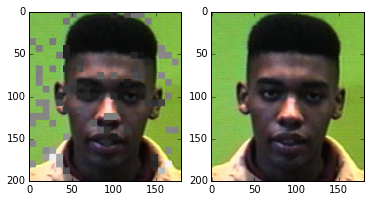

Candidate (fuzzy)  hdfs://ip-10-123-209-104:9000/fuzzy/malernpwilrnpwil.2.jpg
Matched (original)  hdfs://ip-10-123-209-104:9000/imgs/malernpwilrnpwil.2.jpg


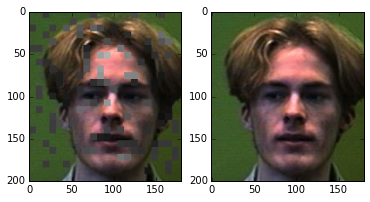

In [9]:
def load_image(image):
    """Load one image, where image = (key, blob)"""
    from StringIO import StringIO
    from PIL import Image
    img_quads = []
    img = Image.open(StringIO(image[1]))
    return  image[0], np.asarray(img, dtype=np.uint8)

for p in phash_and_ward:
    cname, candidate = load_image(sc.binaryFiles(p[0]).collect()[0])
    mname, matched = load_image(sc.binaryFiles(p[1][0][0]).collect()[0])
    print("Candidate (fuzzy) " , cname)
    plt.subplot(1,2,1)
    plt.imshow(candidate)
    print("Matched (original) "  ,mname)        
    plt.subplot(1,2,2)
    plt.imshow(matched)
    plt.show()


#### ['config' below shows the yaml config file loaded for this example](#config)
<a id="config"></a>

In [10]:
config = {'actions': ['map_each_image', 'kmeans', 'find_similar'],
 'candidate_batch': 'c1',
 'candidate_has_mapped': False,
 'candidate_measures_spec': '/t1/candidates/c1/measures',
 'candidate_spec': '/fuzzy/*',
 'example_data': '/imgs/',
 'fuzzy_example_data': '/fuzzy/',
 'in_memory_set_len': 8000000,
 'input_spec': '/imgs/*',
 'kmeans_group_converge': 10000,
 'kmeans_output': {'cluster_to_flattened': True,
                   'cluster_to_key': True,
                   'cluster_to_phash': True,
                   'cluster_to_ward': True,
                   'flattened_to_cluster': True,
                   'flattened_to_key': True,
                   'flattened_to_phash': True,
                   'key_to_cluster': True,
                   'key_to_phash': True,
                   'phash_to_cluster': True,
                   'phash_to_flattened': True,
                   'phash_to_key': True,
                   'ward_to_cluster': True,
                   'ward_to_key': True},
 'kmeans_sample': 2000,
 'maxIterations': 15,
 'max_iter_group': 10,
 'n_clusters': 12,
 'n_clusters_group': 8,
 'patch': {'max_patches': 4,
           'random_state': 0,
           'window_as_fraction': [0.5, 0.5]},
 'phash_bits': 1024,
 'phash_chunk_len': 2,
 'quantiles': [5, 15, 25, 50, 75, 95],
 'search_rounds': 1,
 'search_sample_step': 100,
 'test_name': 't1',
 'ward_clusters': 12,
 'ward_x_down': 16,
 'x_down': 32}